In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from datetime import datetime
from kneed import KneeLocator
import matplotlib.pyplot as plt
from neural_analysis.matIO import loadmat
import numpy as np
import os
import pandas as pd
from statsmodels.tsa.api import VAR
import sys
import time
from tqdm.auto import tqdm

sys.path.append('/om2/user/eisenaj/code/repos/local-linear-segmentation/segmentation_code')
import LLSA as lvar
import LLSA_calculations as lvarc

sys.path.append('../../..')
from utils import get_data_class, load, save

In [3]:
## propofolPuffTone
session = 'Mary-Anesthesia-20160809-01'
# session = 'MrJones-Anesthesia-20160105-01'
# session = 'MrJones-Anesthesia-20160113-01'
# session = 'Mary-Anesthesia-20160818-02'
# session = 'MrJones-Anesthesia-20160121-01'

## propofolWakeup
# session = 'Mary-Anesthesia-20170203-02'

## ketamine
# session = 'Mary-Anesthesia-20170315-01'
# session = 'MrJones-Anesthesia-20160805-01'
# session = 'MrJones-Anesthesia-20160808-01'
# session = 'Mary-Anesthesia-20170315-01'

## Load Neural Data

In [4]:
all_data_dir = f"/om/user/eisenaj/datasets/anesthesia/mat"
data_class = get_data_class(session, all_data_dir)

In [5]:
filename = os.path.join(all_data_dir, data_class, f'{session}.mat')
print("Loading data ...")
start = time.process_time()
electrode_info, lfp, lfp_schema, session_info, spike_times, trial_info, unit_info = loadmat(filename, variables=['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'trialInfo', 'unitInfo'], verbose=False)
spike_times = spike_times[0]
dt = lfp_schema['smpInterval'][0]
# T = lfp.shape[0]

print(f"Data loaded (took {time.process_time() - start:.2f} seconds)")

Loading data ...
Data loaded (took 151.50 seconds)


# Try and Find the Minimum Window Size

In [6]:
area = 'vlPFC'
if area == 'all':
    unit_indices = np.arange(lfp.shape[1])
else:
    unit_indices = np.where(electrode_info['area'] == area)[0]

In [7]:
# minimum_window_options = [0.5, 0.75, 1]
n_test_windows = 100

minimum_window_options = np.arange(0.5, 2, 0.1)
minimum_window_options = np.arange(0.1, 1, 0.05)
# n_test_windows = 1200

conds_w = np.zeros((len(minimum_window_options), n_test_windows))
conds_cov_w = np.zeros(conds_w.shape)

iterator = tqdm(total=np.prod(conds_w.shape))
for i, window_seconds in enumerate(minimum_window_options):
    window = int(window_seconds/dt)
    for j in range(n_test_windows):
        start_t = np.random.randint(0, lfp.shape[0] - window)
        window_data = lfp[start_t:start_t + window, unit_indices]
        conds_w[i, j] = np.linalg.cond(np.cov(window_data.T))
        
#         # statsmodels.tsa.api
#         model = VAR(window_data)
#         VAR_results = model.fit(1)
#         inter, coef, cov = VAR_results.intercept, VAR_results.coefs[0], VAR_results.sigma_u
        
        # cython implementation
        theta,eps=lvarc.get_theta(window_data,1)
        inter,coef,cov=lvarc.decomposed_theta(theta)
        coef = coef.T
        
        conds_cov_w[i, j] = np.linalg.cond(cov)
        
        iterator.update()
iterator.close()

  0%|          | 0/1800 [00:00<?, ?it/s]

In [8]:
def bootstrap(l,n_times,n_samples=1000,confidence_interval=95):
    if n_samples>len(l):
        n_samples=len(l)*2
    per=(100-confidence_interval)/2
    new_means=[]
    for i in range(n_times):
        indices=np.random.choice(range(0,len(l)),n_samples)#len(l))
        new_list=[l[idx] for idx in indices]
        new_means.append(np.median(new_list,axis=0))
    new_means=np.vstack(new_means)
    cil=np.zeros(new_means.shape[1])
    ciu=np.zeros(new_means.shape[1])
    for i in range(new_means.shape[1]):
        cil[i]=np.percentile(new_means[:,i],per)
        ciu[i]=np.percentile(new_means[:,i],100-per)
    return np.median(l,axis=0),cil,ciu

In [9]:
median_w=[]
median_cil_w=[]
median_ciu_w=[]
median_cov_w=[]
median_cil_cov_w=[]
median_ciu_cov_w=[]
for k in tqdm(range(len(conds_w))):
    median,cil,ciu=bootstrap(conds_w[k], n_test_windows)
    median_w.append(median)
    median_cil_w.append(cil)
    median_ciu_w.append(ciu)
    median,cil,ciu=bootstrap(conds_cov_w[k], n_test_windows)
    median_cov_w.append(median)
    median_cil_cov_w.append(cil)
    median_ciu_cov_w.append(ciu)

  0%|          | 0/18 [00:00<?, ?it/s]

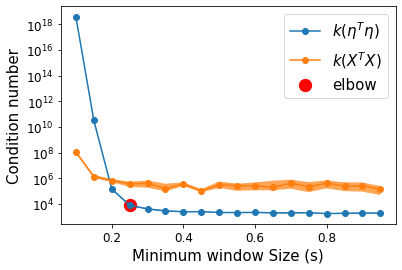

In [10]:
plt.plot(minimum_window_options,np.hstack(median_cov_w),marker='o',label='$k(\eta^T\eta)$')
plt.fill_between(minimum_window_options,np.hstack(median_cil_cov_w),np.hstack(median_ciu_cov_w),alpha=.7)
plt.plot(minimum_window_options,np.hstack(median_w),marker='o',label='$k(X^TX)$')
plt.fill_between(minimum_window_options,np.hstack(median_cil_w),np.hstack(median_ciu_w),alpha=.7)
# kneedle = KneeLocator(minimum_window_options, median_cov_w, S=2, curve='convex', direction='decreasing')
# plt.scatter(kneedle.elbow, kneedle.elbow_y, c='red', marker='o', label='elbow', s=150)
kneedle = KneeLocator(minimum_window_options, np.log10(median_cov_w), S=2, curve='convex', direction='decreasing')
plt.scatter(kneedle.elbow, np.power(10, kneedle.elbow_y), c='red', marker='o', label='elbow', s=150)
plt.ylabel('Condition number',fontsize=15)
plt.xlabel('Minimum window Size (s)',fontsize=15)
plt.yscale('log')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.xlim(guess_dims,20)
plt.legend(fontsize=15)
plt.show()

In [11]:
# the value of w0 should be guided by the previous plot
# stop when you get to more than 10 times as big as w0
w0=0.25
step_fraction=.25
i=w0
window_options=[]
while i < np.inf:
    window_options.append(i)
    step=i*step_fraction
    if int(i*step_fraction)>w0:
        break
    i+=step
print(f"window_options = {[float(f'{w:.3f}') for w in window_options]}")

window_options = [0.25, 0.312, 0.391, 0.488, 0.61, 0.763, 0.954, 1.192, 1.49, 1.863, 2.328, 2.91, 3.638, 4.547]


# Adaptive segmentation

As discussed in the SegmentingHO.ipynb notebook, there are plenty of places along our pipeline where we can get a significant speed up by parallelizing the calculations. In this toy example, we haven't explicitly done any parallel calculation, as the nature of the parallelization will be specific to the data and the purpose of the analysis. A few examples of parallelizable parts include:

1) Likelihood ratio distribution: we need to do the exact same calculation N times

2) Parallelize over different time series, or pre-split the time series into chunks and parallelize over them

3) In the calculation of the distance matrix we can both parallelize one of the loops and also only compute the upper triangular or lower triangular matrix since, by construction, the matrix will be symmetric

In [ ]:
N=20
per=97.5
cond_thresh = np.power(10, np.ceil(kneedle.elbow_y))
sample_tseries=lfp[:45*60*1000, ]
window_options_ms = [int(w/dt) for w in window_options]
#apply segmentation algorithm
breaks_segments=lvar.change_point(window_options_ms,N,per,np.ma.array(sample_tseries),20,cond_thresh=cond_thresh, verbose=True) 
#cond_thresh is chosen in accordance to the condition number plot

In [ ]:
save(break_segments, '/om/user/eisenaj/break_segments')

In [ ]:
N

In [ ]:
windows_segment,segments=breaks_segments
#compute thetas in the obtained windows_segment
thetas_final=[]
for idx,seg in enumerate(segments):
    segment_windows=np.copy(windows_segment[idx])
    segments_windows=list(segment_windows)
    thetas=[]
    for seg_w in segment_windows:
        i_0,i_f=seg_w
        window_bw=sample_tseries[i_0:i_f]
        theta,eps=lvarc.get_theta(window_bw,1)
        thetas.append(np.vstack(theta))
    thetas_final.append(thetas)
thetas_final=np.concatenate(thetas_final)
windows_final=np.concatenate(windows_segment)

In [ ]:
windows_final

In [ ]:
criticality_indices = np.zeros((len(windows_final), lfp.shape[1]))
for i, theta in enumerate(thetas_final):
    c,A,cov=lvarc.decomposed_theta(theta)
    A = A.T
    e = np.linalg.eigvals(A)
    criticality_indices[i] = np.abs(e)
#     coef=(A-np.identity(theta.shape[1]))*frameRate
#     all_eigs.append(np.linalg.eigvals(coef))

In [ ]:
window_locs = [w.mean()*dt for w in windows_final]
plt.plot(window_locs, criticality_indices.mean(axis=1))
plt.xlabel('Time (s)')
plt.show()

# Try Again

In [51]:
N = 50
breaks_segments2=lvar.change_point(window_options_ms,N,per,np.ma.array(sample_tseries),20,cond_thresh=cond_thresh, verbose=True) 

Now segmenting the time series...


  0%|          | 0/24750 [00:00<?, ?it/s]

Removing artificial breaks...


In [55]:
windows_segment,segments=breaks_segments2
#compute thetas in the obtained windows_segment
thetas_final=[]
for idx,seg in enumerate(segments):
    segment_windows=np.copy(windows_segment[idx])
    segments_windows=list(segment_windows)
    thetas=[]
    for seg_w in segment_windows:
        i_0,i_f=seg_w
        window_bw=sample_tseries[i_0:i_f]
        theta,eps=lvarc.get_theta(window_bw,1)
        thetas.append(np.vstack(theta))
    thetas_final.append(thetas)
thetas_final=np.concatenate(thetas_final)
windows_final=np.concatenate(windows_segment)

In [56]:
windows_final

array([[    0,  5278],
       [ 5278, 19529],
       [19529, 25000]])